---
## **GS Workshop Session 1**
#### **date: "06/20/2022"**
---

#### **Source Scripts and Load Data**


In [2]:
WorkDir <- "/panfs/roc/groups/13/lorenza/vramasub/GS_Workshop/"
setwd(WorkDir)

##Source in functions to be used
source("/panfs/roc/groups/13/lorenza/vramasub/GS_Workshop/GS_Pipeline_Jan_2022_FnsApp.R")
source("/panfs/roc/groups/13/lorenza/vramasub/GS_Workshop/bootcamp_functions.R")





   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union



Attaching package: 'bWGR'


The following objects are masked from 'package:NAM':

    CNT, GAU, GRM, IMP, KMUP, KMUP2, SPC, SPM, emBA, emBB, emBC, emBL,
    emCV, emDE, emEN, emGWA, emML, emML2, emRR, markov, mkr, mkr2X,
    mrr, mrr2X, mrrFast, wgr


Loading required package: AlgDesign

Loading required package: scales

Loading required package: scatterplot3d

Loading required package: emoa


Attaching package: 'emoa'


The following object is masked from 'package:dplyr':

    coalesce


Loading required package: Matrix

Loading required package: MASS


Attaching package: 'MASS'


The following ob

#### ** Read Genotype File using vcfR ** ####

In [3]:

##Load in genotype data. Use package vcfR to read in and work with vcf file.
infileVCF <- "SoyNAM_Geno.vcf"
genotypes_VCF <- read.table(infileVCF)
vcf <- read.vcfR(infileVCF, verbose = FALSE)



#### **Convert VCF file format to numerical matrix format.**
#### Final genotype matrix is geno_num

In [4]:
gt <- extract.gt(vcf, element = "GT", as.numeric = F)
fix_T <- as_tibble(getFIX(vcf))
gt2 <- matrix(0, ncol = ncol(gt), nrow = nrow(gt))
colnames(gt2) <- colnames(gt)
rownames(gt2) <- rownames(gt)
gt2a <- apply(gt,2, function(x) gsub("1/1","1",x))
gt2b <- gsub("0[/|]0","0",gt2a)
gt2c <- gsub("[10][/|][10]","0.5",gt2b)
gt2d <- gsub("\\.[/|]\\.","NA",gt2c)

gt2d_num<- apply(gt2d,2,as.numeric)
rownames(gt2d_num)<- rownames(gt2d)
geno_num <- t(gt2d_num) 


#### **Filter Genotypic Data**

In [5]:
##Filter markers on % missing
miss <- function(x){length(which(is.na(x)))}
mrkNA <- (apply(geno_num, MARGIN=2, FUN=miss))/dim(geno_num)[1]
ndx <- which(mrkNA > 0.2)

if (length(ndx)>0) geno_num2 <- geno_num[, -ndx] else geno_num2 <- geno_num

##Filter individuals on % missing
indNA <- (apply(geno_num2, MARGIN=1, FUN=miss))/dim(geno_num2)[2]
ndx2 <- which(indNA > 0.5)

 if(length(ndx2)>0) geno_num3 <- geno_num2[-ndx2, ] else geno_num3 <- geno_num2


##Filter markers based on MAF
maf <- apply(geno_num3, MARGIN=2, FUN=mean, na.rm=T)
ndx3 <- which(maf<0.05 | maf>0.95) 

if (length(ndx3)>0) geno_num4 <- geno_num2[, -ndx3] else geno_num4 <- geno_num3
  

#### **Import Phenotypic Data**

In [6]:

##Import phenotypic data  for one family toy set

pheno <- read.csv("soynam_blups_yld.csv")

##Match phenotypic data to marker data

ndx4 <- match(rownames(geno_num4), pheno$RIL)
ndxNA <- which(is.na(ndx4))
ndx5 <- ndx4[-ndxNA]

pheno_sub <- pheno[ndx5, ]
geno_num5 <- geno_num4[-ndxNA, ]


#### **Imputation of Simulated Genotypic Values**

In [7]:

##Impute using Naive imputation

# geno_imp <- replaceNAwithMean(geno_num5)
geno_imp <- markov(geno_num5)

#### **Fit GP Models using BGLR**
##### **Bayes B**

--------------------> Summary of data & model <-------------------- 

 Number of phenotypes= 5148 
 Min (TRN)=  2594.833 
 Max (TRN)=  4400.046 
 Variance of phenotypes (TRN)= 69099.32 
 Residual variance= 56128.31 
 N-TRN= 5148   N-TST=0 


 -- Linear Predictor -- 

 Intercept included by default
 Coefficientes in ETA[ 1 ] (  ) modeled as in  BayesB 

------------------------------------------------------------------


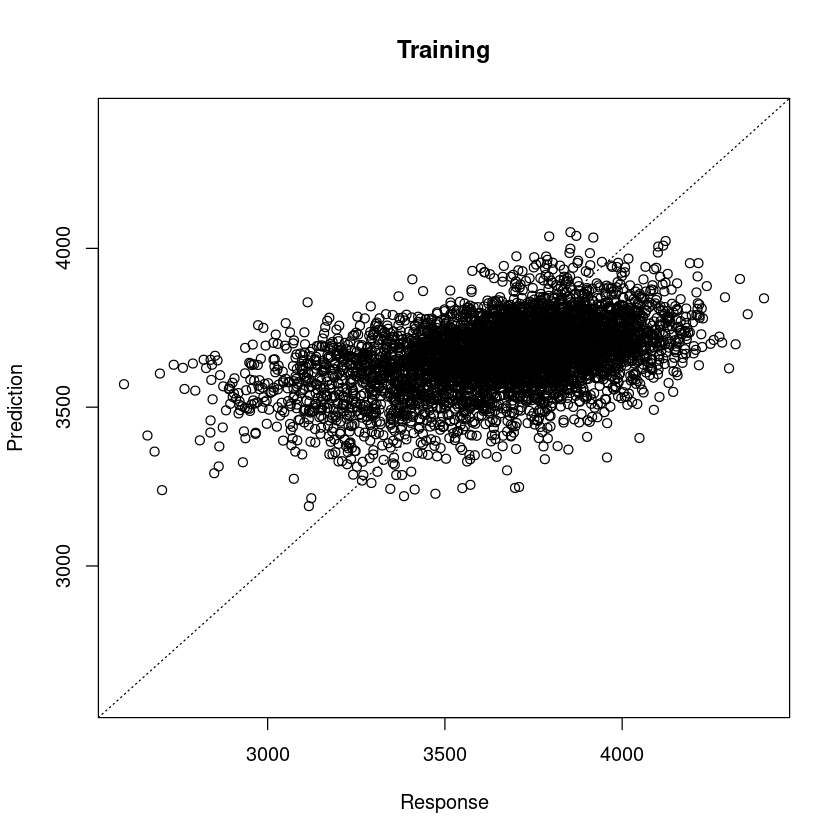

In [8]:

##Fit several models using BGLR

#BayesB
ETA_BB <- list(list(X=geno_imp, model='BayesB', probIn=.10))
modelBB <- BGLR(y=pheno_sub$Yield_blup, ETA=ETA_BB, burnIn=1000, nIter=2000, verbose=FALSE)
bbGebvs <- modelBB$yHat



summary(modelBB)
plot(modelBB)

##### **Bayes RR**

In [9]:

##BayesRR
ETA_BRR <- list(list(X=geno_imp, model='BRR', probIn=.10))
modelBRR <- BGLR(y=pheno_sub$Yield_blup, ETA=ETA_BRR, burnIn=1000, nIter=2000, verbose=FALSE)
summary(modelBRR)


--------------------> Summary of data & model <-------------------- 

 Number of phenotypes= 5148 
 Min (TRN)=  2594.833 
 Max (TRN)=  4400.046 
 Variance of phenotypes (TRN)= 69099.32 
 Residual variance= 55142.96 
 N-TRN= 5148   N-TST=0 


 -- Linear Predictor -- 

 Intercept included by default
 Coefficientes in ETA[ 1 ] (  ) modeled as in  BRR 

------------------------------------------------------------------


##### **Bayes C**

--------------------> Summary of data & model <-------------------- 

 Number of phenotypes= 5148 
 Min (TRN)=  2594.833 
 Max (TRN)=  4400.046 
 Variance of phenotypes (TRN)= 69099.32 
 Residual variance= 55965.41 
 N-TRN= 5148   N-TST=0 


 -- Linear Predictor -- 

 Intercept included by default
 Coefficientes in ETA[ 1 ] (  ) modeled as in  BayesC 

------------------------------------------------------------------


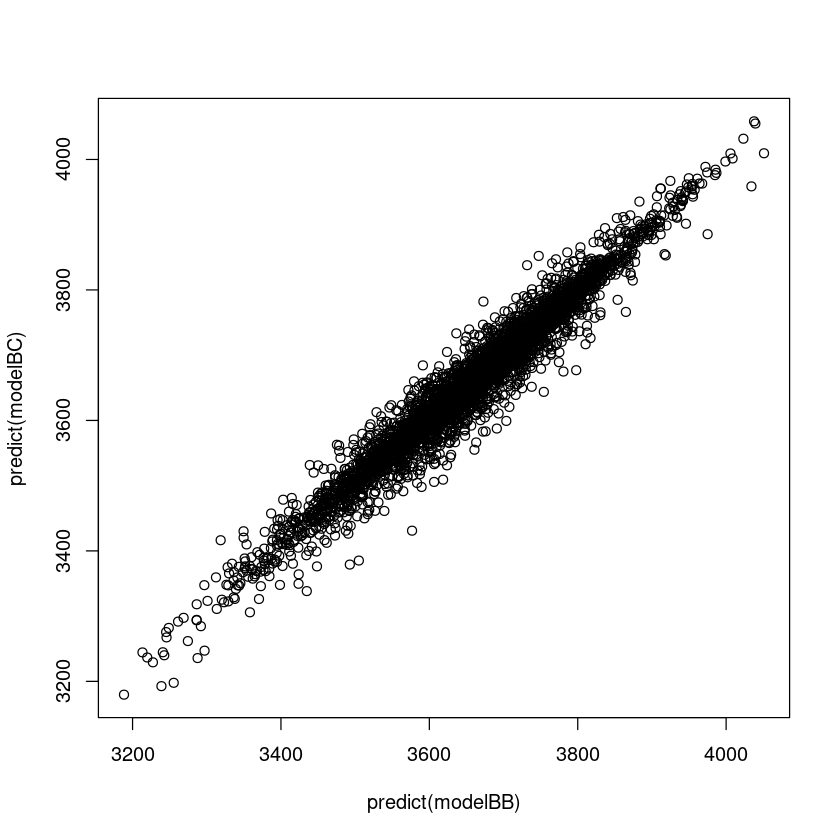

In [10]:

##BayesC
ETA_BC <- list(list(X=geno_imp, model='BayesC', probIn=.10))
modelBC <- BGLR(y=pheno_sub$Yield_blup, ETA=ETA_BC, burnIn=1000, nIter=2000, verbose=FALSE)
summary(modelBC)
plot(predict(modelBB), predict(modelBC))


In [11]:

### 
 
##Fit several models using SOMMER

### Multi-Environ / CS 


pheno <- read.csv("SoyNAM_Pheno.csv")
geno_num4_x <- cbind(rownames(geno_num4),geno_num4)

colnames(geno_num4_x)[1]<- "strain"
## Merge Geno and Pheno Data
Data <- merge(geno_num4_x,pheno,by="strain",all=TRUE)

## Remove with missing yiled_blup values 

YldNA_Indices <- which(is.na(Data$yield))
Data_Sub <- Data[-YldNA_Indices,]


genoStrain <- unique(geno_num4_x[,"strain"])
genoStrainIndices <- which(Data_Sub[,"strain"] %in% genoStrain)

genoIndices <- grep("ss",colnames(geno_num4_x))
initGenoIndx <- genoIndices[1]
finalGenoIndx <- genoIndices[length(genoIndices)]
phenoIndices <- c(1,c((finalGenoIndx+1):ncol(Data_Sub)))

pheno_sub <- Data_Sub[genoStrainIndices,phenoIndices]
geno_num4b <- Data_Sub[genoStrainIndices,c(1,genoIndices)]

uniqueStrainIndices<- which(!duplicated(geno_num4b[,"strain"]))
geno_num5 <- geno_num4b[uniqueStrainIndices,]

## Check 

### set 'yield' colname to 'Yield_blup'

yldCol <- which(colnames(pheno_sub) %in% "yield")
colnames(pheno_sub)[yldCol] <- "Yield_blup" 

### Select 3 environs with largest number of evaluations (lines)  

env_sub <-  names(which(table(pheno_sub[,"environ"])>5100)[1:3])

env_sub_indices <- which(pheno_sub[,"environ"] %in% env_sub)

## Subset Data and Geno tables 
DT <- pheno_sub[env_sub_indices,]

DT$environ <- as.factor(DT$environ)


In [12]:


#### Impute genotable

geno_imp <- markov(apply(geno_num5[,-1],2,as.numeric))
rownames(geno_imp) <- geno_num5[,"strain"]


In [13]:

###
env_geno_sub_indices <- which(rownames(geno_imp) %in% unique(DT[,"strain"]))
geno_imp_sub <- geno_imp[env_geno_sub_indices,]



In [14]:
K_rr <- A.mat(geno_imp_sub)
colnames(K_rr) <-rownames(geno_imp_sub)
rownames(K_rr) <- rownames(geno_imp_sub)
A <- K_rr

### Limit no_of_environments to create EA matrix of reasonable mem size.. 

A_Sub <- A[1:500,1:500]
DT_Sub <- DT[which(DT[,"strain"] %in% rownames(A_Sub)),]

E <- diag(length(unique(DT$environ)))
rownames(E) <- colnames(E) <- unique(DT$environ)
DT_Sub$environ <- as.factor(DT_Sub$environ)

In [15]:

### Same set of strains in each of the environments 

rmStrains <- names(which(table(DT_Sub[,"strain"]) <3))
DT_Sub1 <- DT_Sub[-which(DT_Sub[,"strain"] %in% rmStrains),]

A_Sub1 <- A_Sub[-which(rownames(A_Sub) %in% rmStrains),-which(rownames(A_Sub) %in% rmStrains)]

### Avg yield of strains across 3 locations
DT_Sub1_Tb <- as_tibble(DT_Sub1)
DT_Sub1_Strain <- DT_Sub1_Tb %>% group_by(strain)
DT_Sub1_Strain_Comb <- (DT_Sub1_Strain) %>% summarise( 
    Yield_blup =mean(Yield_blup,na.rm=TRUE))

### Avg yield in 3 env

DT_Sub1_Tb <- as_tibble(DT_Sub1)
DT_Sub1_env <- DT_Sub1_Tb %>% group_by(environ)
DT_Sub1_env_Comb <- (DT_Sub1_env) %>% summarise( 
  Yield_blup =mean(Yield_blup,na.rm=TRUE))


### *** Exercise - Compare several var-covar structures in SOMMER package ***


#### **Fit SOMMER model with CS var-covar structure** ####

In [17]:

E <- diag(length(unique(DT_Sub1$environ)))
rownames(E) <- colnames(E) <- unique(DT_Sub1$environ)

EA <- kronecker(E,A_Sub1, make.dimnames = TRUE)
DT_Sub1$environ <- as.factor(DT_Sub1$environ)
DT_Sub1$strain <- as.factor(DT_Sub1$strain)

fitCS <- mmer(Yield_blup~environ-1,
              random= ~ vs(strain, Gu=A_Sub1) + vs(environ:strain, Gu=EA),
              rcov= ~ units,
              data=DT_Sub1, verbose = FALSE)
summary(fitCS)

========================================================================
               Multivariate Linear Mixed Model fit by REML               
****************************  sommer 4.1  **************************** 
========================================================================
         logLik      AIC      BIC Method Converge
Value -523.9647 1053.929 1069.833     NR     TRUE
========================================================================
Variance-Covariance components:
                                       VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup               0     11503  0.000   Positive
u:environ:strain.Yield_blup-Yield_blup   65969     20118  3.279   Positive
units.Yield_blup-Yield_blup             343674     13301 25.838   Positive
========================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3147     28.55  110.24
2 Yield_blup environIA_2013     2779     28.55   97.33
3 Yield_blup environIL_2012     3633     28.55  127.27
========================================================================
Groups and observations:
                 Yield_blup
u:strain                494
u:environ:strain       1482
========================================================================
Use the '$' sign to access results and parameters

#### **Main Effect** ####

In [21]:

fitMain <- mmer(Yield_blup~environ-1,
                random=~vs(strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1,verbose=FALSE)
summary(fitMain)


================================================================
           Multivariate Linear Mixed Model fit by REML           
************************  sommer 4.1  ************************ 
================================================================
         logLik      AIC     BIC Method Converge
Value -545.1281 1096.256 1112.16     NR     TRUE
================================================================
Variance-Covariance components:
                               VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup   13377      7394  1.809   Positive
units.Yield_blup-Yield_blup     372917     13908 26.813   Positive
================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3134        28   111.9
2 Yield_blup environIA_2013     2801        28   100.0
3 Yield_blup environIL_2012     3617        28   129.2
================================================================
Groups and observations:
         Yield_blup
u:strain        494
================================================================
Use the '$' sign to access results and parameters

#### **Diagonal Structure** ####

In [22]:
fitDG <- mmer(Yield_blup~environ-1,
              random=~vs(ds(environ),strain,Gu=A_Sub1),
              rcov=~units,
              data=DT_Sub1,verbose=FALSE)

summary(fitDG)


======================================================================
              Multivariate Linear Mixed Model fit by REML              
***************************  sommer 4.1  *************************** 
======================================================================
         logLik      AIC      BIC Method Converge
Value -521.5774 1049.155 1065.058     NR     TRUE
======================================================================
Variance-Covariance components:
                                     VarComp VarCompSE Zratio Constraint
IA_2012:strain.Yield_blup-Yield_blup   21787     15811  1.378   Positive
IA_2013:strain.Yield_blup-Yield_blup   95090     35633  2.669   Positive
IL_2012:strain.Yield_blup-Yield_blup   91533     34819  2.629   Positive
units.Yield_blup-Yield_blup           342872     13262 25.853   Positive
======================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3138     27.36  114.67
2 Yield_blup environIA_2013     2777     29.06   95.57
3 Yield_blup environIL_2012     3636     29.00  125.38
======================================================================
Groups and observations:
               Yield_blup
IA_2012:strain        494
IA_2013:strain        494
IL_2012:strain        494
======================================================================
Use the '$' sign to access results and parameters

#### **CS - Diagonal Structure** ####

In [24]:
fitCSDG <- mmer(Yield_blup~environ,
                random=~vs(strain,Gu=A_Sub1) +vs(ds(environ),strain,Gu=A_Sub1),
                rcov=~units,
                data=DT_Sub1,verbose=FALSE) 


### **Exercise - Predict performance of lines in untested environments using CS structure** ###

In [30]:
### Lines that are present 

### Remove lines from IA2013 and train the model with CS structure using IA2012 and IL2013 only and predict 
### performance of lines for IA2013 and compare accuracy with model 
### incorporating data from IA2013 in the training model  

 length(fitCS$U$`u:strain`)
 summary(fitCS$U$`u:environ:strain`$Yield_blup)

 length(DT_Sub1[,"Yield_blup"])
 length(fitCS$U$`u:environ:strain`$Yield_blup) 

 cor(fitCS$U$`u:environ:strain`$Yield_blup,DT_Sub1[,"Yield_blup"])








[1] 1

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-468.256 -108.642   -8.275   -6.196  105.691  448.902 

[1] 1482

[1] 1482

[1] 0.05253406

In [31]:
fitCS$Beta

Trait,Effect,Estimate
<fct>,<fct>,<dbl>
Yield_blup,environIA_2012,3146.983
Yield_blup,environIA_2013,2778.546
Yield_blup,environIL_2012,3633.347


In [68]:
m <- model.matrix(~ environ-1 ,data=DT_Sub1)
m_beta <- m %*% as.numeric(fitCS$Beta[,3]) 
Pred <- m_beta+fitCS$U$`u:environ:strain`$Yield_blup
cor(Pred,DT_Sub1[,"Yield_blup"])

0.4676182


In [53]:
tstIndices1 <- which(DT_Sub1[,"environ"] %in% "IA_2013") 

DT_Sub1A <- DT_Sub1
DT_Sub1A[tstIndices1 ,"Yeild_blup"] <- NA
#DT_Sub1A[tstIndices1 ,"environ"] <- NA

dim(DT_Sub1A)

[1] 1482   18

In [56]:

E <- diag(length(unique(DT_Sub1A$environ)))
rownames(E) <- colnames(E) <- unique(DT_Sub1A$environ)
dim(E)

EA <- kronecker(E,A_Sub1, make.dimnames = TRUE)
DT_Sub1$Aenviron <- as.factor(DT_Sub1A$environ)
DT_Sub1A$strain <- as.factor(DT_Sub1A$strain) 

dim(EA)

[1] 3 3

[1] 1482 1482

In [57]:



fitCS1A <- mmer(Yield_blup~environ-1,
              random= ~ vs(strain, Gu=A_Sub1) + vs(environ:strain, Gu=EA),
              rcov= ~ units,
              data=DT_Sub1A, verbose = FALSE)
summary(fitCS1A)


========================================================================
               Multivariate Linear Mixed Model fit by REML               
****************************  sommer 4.1  **************************** 
========================================================================
         logLik      AIC      BIC Method Converge
Value -523.9647 1053.929 1069.833     NR     TRUE
========================================================================
Variance-Covariance components:
                                       VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup               0     11503  0.000   Positive
u:environ:strain.Yield_blup-Yield_blup   65969     20118  3.279   Positive
units.Yield_blup-Yield_blup             343674     13301 25.838   Positive
========================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3147     28.55  110.24
2 Yield_blup environIA_2013     2779     28.55   97.33
3 Yield_blup environIL_2012     3633     28.55  127.27
========================================================================
Groups and observations:
                 Yield_blup
u:strain                494
u:environ:strain       1482
========================================================================
Use the '$' sign to access results and parameters

In [67]:
m <- model.matrix(~ environ-1 ,data=DT_Sub1)
m_beta <- m %*% as.numeric(fitCS1A$Beta[,3]) 
tstPred1 <- (m_beta+fitCS1A$U$`u:environ:strain`$Yield_blup)[tstIndices1]
length(tstPred1)
cor(tstPred1,DT_Sub1[tstIndices1,"Yield_blup"])


[1] 494

[1] 0.1316652

In [63]:
tstIndices1 <- which(DT_Sub1[,"environ"] %in% "IA_2013") 
set.seed(125)
tstIndices2 <- sample(tstIndices1,0.5*length(tstIndices1))
length(tstIndices1)
length(tstIndices2)
DT_Sub1B <- DT_Sub1
DT_Sub1B[tstIndices2 ,"Yeild_blup"] <- NA
#DT_Sub1A[tstIndices1 ,"environ"] <- NA

dim(DT_Sub1B)

[1] 494

[1] 247

[1] 1482   18

In [64]:

E <- diag(length(unique(DT_Sub1B$environ)))
rownames(E) <- colnames(E) <- unique(DT_Sub1B$environ)
dim(E)

EA <- kronecker(E,A_Sub1, make.dimnames = TRUE)
DT_Sub1B$environ <- as.factor(DT_Sub1B$environ)
DT_Sub1B$strain <- as.factor(DT_Sub1B$strain) 

dim(EA)

[1] 3 3

[1] 1482 1482

In [65]:


fitCS1B <- mmer(Yield_blup~environ-1,
              random= ~ vs(strain, Gu=A_Sub1) + vs(environ:strain, Gu=EA),
              rcov= ~ units,
              data=DT_Sub1B, verbose = FALSE)
summary(fitCS1B)

========================================================================
               Multivariate Linear Mixed Model fit by REML               
****************************  sommer 4.1  **************************** 
========================================================================
         logLik      AIC      BIC Method Converge
Value -523.9647 1053.929 1069.833     NR     TRUE
========================================================================
Variance-Covariance components:
                                       VarComp VarCompSE Zratio Constraint
u:strain.Yield_blup-Yield_blup               0     11503  0.000   Positive
u:environ:strain.Yield_blup-Yield_blup   65969     20118  3.279   Positive
units.Yield_blup-Yield_blup             343674     13301 25.838   Positive
========================================================================
Fixed effects:
       Trait         Effect Estimate Std.Error t.value
1 Yield_blup environIA_2012     3147     28.55  110.24
2 Yield_blup environIA_2013     2779     28.55   97.33
3 Yield_blup environIL_2012     3633     28.55  127.27
========================================================================
Groups and observations:
                 Yield_blup
u:strain                494
u:environ:strain       1482
========================================================================
Use the '$' sign to access results and parameters

In [66]:
m <- model.matrix(~ environ-1 ,data=DT_Sub1)
m_beta <- m %*% as.numeric(fitCS1B$Beta[,3]) 
tstPred2 <- (m_beta+fitCS1B$U$`u:environ:strain`$Yield_blup)[tstIndices2]
length(tstPred2)
cor(tstPred2,DT_Sub1[tstIndices2,"Yield_blup"])


[1] 247

[1] 0.2066878